In [43]:
import pandas as pd
from pathlib import Path

from data.points import ANCHORS
filename = "data/movement/2023-05-24-13:52:11.266488_P3-1-6-5_normalized_high_up.csv"
# filename = "data/movement/2023-05-24-14:18:43.048591P3-1-6-5_high_los.csv"
# filename = "data/movement/2023-05-24-14:35:08.828772P3-1-6-5_high_los.csv"
df = pd.read_csv(filename, index_col=0)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df[df.anchor.isin(ANCHORS.keys())]
df = df.set_index("timestamp")

In [44]:
# Create column for every anchor
n_anchors = len(ANCHORS)
df = df.pivot(columns="anchor", values="distance").fillna(0).rolling(window=n_anchors, step=n_anchors).sum().dropna()

In [45]:
# Simple filtering
df=df.rolling(window=3).mean().dropna()

In [46]:
from easy_trilateration.model import *
from easy_trilateration.least_squares import easy_least_squares, solve_history
from easy_trilateration.graph import *
from helpers import distance

history = []

for timestamp, row in df.iterrows():
    c = [Circle(*ANCHORS[anchor], row[anchor]) for anchor in ANCHORS.keys()]
    history.append(Trilateration(c))

solve_history(history)


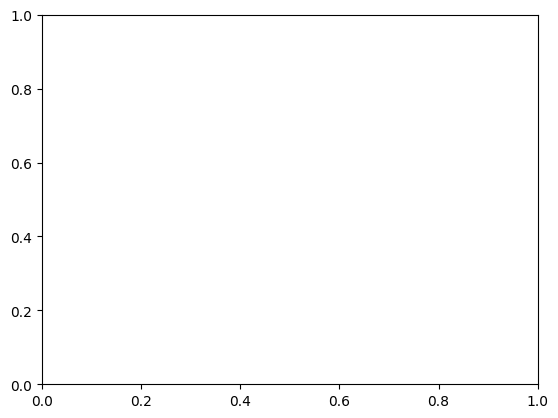

/home/piotr/Documents/mgr/uwb-rs/data-processing/.venv/lib/python3.11/site-packages/matplotlib/animation.py:884: UserWarning:

Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.



In [47]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

ax = plt.subplot()
ax.add_line(Line2D((1560,-5000),(1560,5000)))
a = animate(history, ax)
# with open("video.html", "w") as file:
#     file.write(a.to_html5_video())


In [48]:
data = {
    "x": [],
    "y": [],
    "radius": [],
    "timestamp": df.index.to_list()
}
for t in history:
    t: Trilateration
    data["x"].append(t.result.center.x)
    data["y"].append(t.result.center.y)
    data["radius"].append(t.result.radius)

df = pd.DataFrame(data)

In [49]:
import plotly.graph_objects as go
import plotly.express as px

anchors_df = pd.DataFrame(ANCHORS, index=["x","y"]).transpose()

trace = px.scatter(df, x="x", y="y")
anchors = px.scatter(anchors_df, x="x", y="y")

fig = go.Figure(trace.data + anchors.data)
fig.update_xaxes(range=[-100,3600])
fig.update_yaxes(range=[-1000,4600])
fig.update_layout(width=700, height=700)
fig.show()

In [50]:
px.scatter(df, x="x", y="y", animation_frame="timestamp",
        #    size="radius",
           range_x=[0,2000], range_y=[0,4000],
           width=300, height=600)

In [51]:
orig = pd.read_csv(filename, index_col=0)
orig["timestamp"] = pd.to_datetime(orig["timestamp"])
df = orig.merge(df, on="timestamp")

df[["timestamp", "acc_x", "acc_y", "acc_z", "x", "y", "radius"]].to_csv(f"data/triangulated/{Path(filename).name}")
